In [165]:
import torch
import torchvision
import torchvision.transforms as transform
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder


In [166]:
torch.cuda.is_available()

True

# Section 1 - Prepare data

Data is loaded from a video and split into frames

In [167]:
from torchvision.transforms import Compose, Resize, ToTensor, RandomHorizontalFlip, RandomVerticalFlip, RandomRotation, ColorJitter
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Define the transformations
transformation = Compose([
    Resize((64, 64)),
    RandomHorizontalFlip(),
    RandomVerticalFlip(),
    RandomRotation(30),
    ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    ToTensor()
])

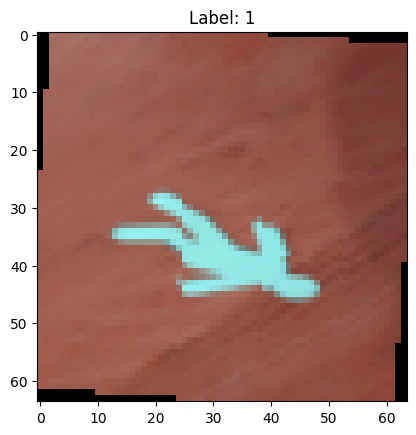

In [168]:
data_dir = "./dataset"
dataset = ImageFolder(root=data_dir, transform=transformation)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)
img, l = None, None
for images, labels in data_loader:
    img, l = images[0], labels[0]
    break
img_test = img.permute(1, 2, 0).numpy()
plt.imshow(img_test)
plt.title(f"Label: {l}")
plt.show()


In [169]:
img.shape

torch.Size([3, 64, 64])

In [170]:
# HYPERPARAMETERS
test_len = 0.3
batch_size = 128
kernel_size = 3
stride = 1
padding = 1

In [171]:
from torch.utils.data import random_split

train_size = int((1-test_len) * len(dataset))
test_size = int(test_len * len(dataset))
extra = len(dataset) - (train_size + test_size)
train_size = train_size + extra if extra > 0 else train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False) # no need to shuffle test data
device = "cuda" if torch.cuda.is_available() else "cpu"

In [172]:
# Define NN
from torch import nn

class VictimCNNModelV0(nn.Module):
    def __init__(self, input_channels, hidden_units, output_size):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_channels,
                out_channels=hidden_units,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(
                in_features=hidden_units*16*16,
                out_features=output_size)
        )
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.classifier(x)
        return x

In [173]:
device

'cuda'

In [174]:
model = VictimCNNModelV0(3, 32, 1).to(device)

In [175]:
model.state_dict()

OrderedDict([('conv1.0.weight',
              tensor([[[[ 0.1084,  0.1443, -0.0462],
                        [ 0.1162,  0.0145,  0.1804],
                        [ 0.1662,  0.1887, -0.1346]],
              
                       [[-0.0816,  0.0866,  0.0374],
                        [-0.1236,  0.0914,  0.1622],
                        [ 0.1213,  0.1064, -0.1116]],
              
                       [[ 0.1621, -0.1172,  0.0732],
                        [-0.0675,  0.0586, -0.0998],
                        [-0.0384, -0.0556,  0.0127]]],
              
              
                      [[[ 0.1716, -0.0818, -0.0504],
                        [ 0.0790, -0.0244, -0.1082],
                        [ 0.1260,  0.1327,  0.1551]],
              
                       [[-0.0172, -0.1469, -0.1497],
                        [-0.0705,  0.0084, -0.1922],
                        [-0.1481, -0.1820,  0.1608]],
              
                       [[-0.1036, -0.1871,  0.0287],
                        

In [176]:
# Find image dimensions for linear layer
model(img.unsqueeze(0).to(device))

tensor([[-0.0158]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [177]:
from torchmetrics import Accuracy
def train_epoch(model,data_loader,loss_fn,optimizer,device):
    train_loss, train_acc = 0,0
    accuracy = Accuracy(task="binary").to(device)
    model.train()
    for batch, (X,y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X).squeeze(1)
        batch_loss = loss_fn(y_pred, y.float())
        train_loss += batch_loss
        y_pred = (y_pred > 0.5).long()
        train_acc += accuracy(y_pred, y)
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%")

def test_epoch(model,data_loader,loss,optimizer,device):
  test_loss, test_acc = 0, 0
  model.eval()
  accuracy = Accuracy(task="binary").to(device)
  with torch.inference_mode():
    for X,y in test_dataloader:
      X,y = X.to(device), y.unsqueeze(1).to(device)
      test_pred = model(X)
      test_loss += loss(test_pred,y.float())
      test_pred = (test_pred > 0.5).long()
      test_acc +=  accuracy(test_pred, y)
    test_loss/=len(data_loader)
    test_acc/=len(data_loader)
  print(f"\nTest loss: {test_loss:.4f}, Test acc: {test_acc:.2f}% \n")


In [ ]:
from tqdm.auto import tqdm

loss = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 4

for i in tqdm(range(epochs)):
    print(f"Epoch {i+1}\n-------------------------------")
    train_epoch(model, train_dataloader, loss, optimizer, device)
    test_epoch(model, test_dataloader, loss, optimizer, device)

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1
-------------------------------
Train loss: 0.49654 | Train acc: 0.76%


In [ ]:
img, l = None, None
for images, labels in train_dataloader:
    img, l = images[0], labels[0]
    break

for batch, (X,y) in enumerate(train_dataloader):
    print(X.shape)
    print(y.shape)

    break

In [ ]:
torch.save(model.state_dict(), 'first_cnn.pth')

In [ ]:
model = VictimCNNModelV0(3, 32, 1)  # Initialize a model with the same architecture
model.load_state_dict(torch.load('first_cnn.pth'))
model.to(device)  # Don't forget to move the model to the device

In [ ]:
from torchvision.transforms import Compose, Resize, ToTensor
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch

# Define the transformation
transformation = Compose([
    Resize((64, 64)),
    ToTensor()
])

# Load the images from the test folder
test_data_dir = "./test"  # Replace with your test folder path
test_dataset = ImageFolder(root=test_data_dir, transform=transformation)

# Create a DataLoader for the test dataset
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
# Load the trained model
model = VictimCNNModelV0(3, 32, 1)  # Initialize a model with the same architecture
model.load_state_dict(torch.load('first_cnn.pth'))
model.to(device)  # Don't forget to move the model to the device
model.eval()  # Set the model to evaluation mode


# Define a function to unnormalize and plot an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Predict the labels for the test images
for images, labels in test_dataloader:
    images = images.to(device)
    outputs = torch.sigmoid(model(images))
    predicted = (outputs > 0.5).long()
    
    # Convert tensors to numpy arrays for visualization
    predicted_np = predicted.cpu().numpy()
    labels_np = labels.numpy()
    
    # Plot the images and display the actual and predicted classes
    for i in range(len(images)):
        print(f"Actual class: {labels_np[i]} | Predicted class: {predicted_np[i]}")
        imshow(images[i].cpu())